<a href="https://colab.research.google.com/github/alibagheribardi/Regression/blob/main/Relocating_reg_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

Original Linear Regression:
  MSE: 24.0119
  R² Score: 0.8503

Rotated Linear Regression:
  MSE: 0.0000
  R² Score: 1.0000


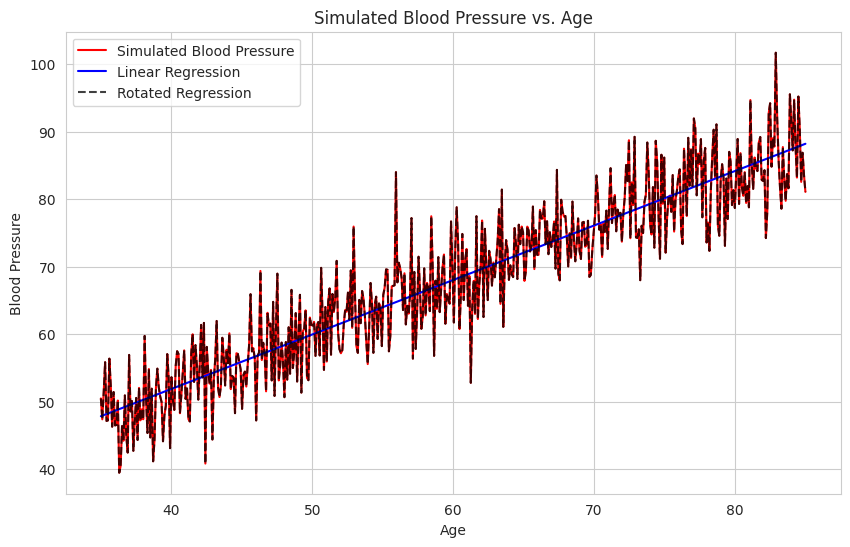

In [25]:

# Simulated data
age = np.linspace(35, 85, 500)
np.random.seed(42)
blood_pressure = 0.8 * age + 20 + np.random.normal(0, 5, size=age.shape)

# Reshape for regression
age_reshaped = age.reshape(-1, 1)

# Original regression
model = LinearRegression()
model.fit(age_reshaped, blood_pressure)
predictions = model.predict(age_reshaped)

# Normalize vectors for alignment
Q_age = age.reshape(-1, 1) / np.linalg.norm(age)
Q_blood_pressure = blood_pressure.reshape(-1, 1) / np.linalg.norm(blood_pressure)

# Orthogonal Procrustes rotation (SVD)
M = Q_blood_pressure @ Q_age.T
U, _, Vt = np.linalg.svd(M)
Rotation = U @ Vt

# Rotate age
Rotated_age = Rotation @ Q_age

# Fit new regression on rotated age
model_rotated = LinearRegression()
model_rotated.fit(Rotated_age, blood_pressure)
Rotated_predictions = model_rotated.predict(Rotated_age)

# Compute metrics
mse_original = mean_squared_error(blood_pressure, predictions)
r2_original = r2_score(blood_pressure, predictions)

mse_rotated = mean_squared_error(blood_pressure, Rotated_predictions)
r2_rotated = r2_score(blood_pressure, Rotated_predictions)

# Print metrics
print("Original Linear Regression:")
print(f"  MSE: {mse_original:.4f}")
print(f"  R² Score: {r2_original:.4f}")

print("\nRotated Linear Regression:")
print(f"  MSE: {mse_rotated:.4f}")
print(f"  R² Score: {r2_rotated:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(age, blood_pressure, label="Simulated Blood Pressure", color='red')
plt.plot(age, predictions, label="Linear Regression", color='blue')
plt.plot(age, Rotated_predictions, label="Rotated Regression", color='black' , ls='--' , alpha=.75)
plt.xlabel("Age")
plt.ylabel("Blood Pressure")
plt.title("Simulated Blood Pressure vs. Age")
plt.grid(True)
plt.legend()
plt.show()


In [55]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load and sort dataset by increasing target value
data = load_diabetes()
X = data.data
y = data.target


# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42
)

# QR decomposition of training set
Q_X, _ = np.linalg.qr(X_train)

# Stack Q_X with y_train as last column
vecs = np.hstack((Q_X[:, :-1], y_train.reshape(-1, 1)))

# QR decomposition of stacked matrix
Q_y, _ = np.linalg.qr(vecs)

# Compute rotation matrix
Rotation = Q_y @ Q_X.T
X_rotated = Rotation @ X_train

# Fit linear regression in rotated space
linear_regression = LinearRegression()
linear_regression.fit(X_rotated, y_train)


# Predict on test set using updated training neighborhood
dist_matrix = euclidean_distances(X_test, X_train)
neighbors = np.argsort(dist_matrix, axis=1)

y_pred = []

for sample, nbhd in zip(X_test, neighbors):
    X_train_updated = X_train.copy()
    X_train_updated[nbhd[0]] = sample  # inject test sample into training set
    sample_rotated = (Rotation @ X_train_updated)[nbhd[0]]  # get rotated version of test sample
    val = linear_regression.predict(sample_rotated.reshape(1, -1))[0]
    y_pred.append(val)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error Rotated): {mse:.2f}")
print(f"R² Score (Rotated): {r2:.4f}")


Mean Squared Error Rotated): 5384.91
R² Score (Rotated): 0.1197


In [43]:
from sklearn.neighbors import KNeighborsRegressor

# Define and fit KNN Regressor
knn = KNeighborsRegressor(n_neighbors=k_opt)
knn.fit(X_train, y_train)

# Predict on the test set
knn_pred = knn.predict(X_test)

# Compute metrics
knn_mse = mean_squared_error(y_test, knn_pred)
knn_r2 = r2_score(y_test, knn_pred)

print(f"[KNN Regressor] Mean Squared Error (MSE): {knn_mse:.2f}")
print(f"[KNN Regressor] R² Score: {knn_r2:.4f}")


[KNN Regressor] Mean Squared Error (MSE): 2646.34
[KNN Regressor] R² Score: 0.5674


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Set seed for reproducibility
np.random.seed(42)

# Generate 500 samples, 10 features
n_samples = 500
n_features = 10

# Create random feature matrix
X = np.random.randn(n_samples, n_features)

# Define a true weight vector for the "true" hyperplane
true_weights = np.random.randn(n_features)

# Generate target values based on linear combination + small Gaussian noise
y = X @ true_weights + np.random.randn(n_samples) * 0.5  # noise level = 0.5

# Print shape
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Fit Linear Regression
reg = LinearRegression()
reg.fit(X, y)

# Predict and evaluate
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")


X shape: (500, 10), y shape: (500,)
R² Score: 0.9708
MSE: 0.2307


In [60]:
# --- Standardize Features ---
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- Split into Train and Test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42
)

# --- QR Decomposition of X_train ---
Q_X, _ = np.linalg.qr(X_train)

# --- Stack Q_X with y_train as last column ---
vecs = np.hstack((Q_X[:, 1:], y_train.reshape(-1, 1)))

# --- QR Decomposition of the new stacked matrix ---
Q_y, _ = np.linalg.qr(vecs)

# --- Compute Rotation Matrix ---
Rotation = Q_y @ Q_X.T
X_rotated = Rotation @ X_train

# --- Fit Linear Regression on Rotated Data ---
linear_regression = LinearRegression()
linear_regression.fit(X_rotated, y_train)

# --- Predict with Rotation per test sample neighborhood ---
dist_matrix = euclidean_distances(X_test, X_train)
neighbors = np.argsort(dist_matrix, axis=1)

y_pred = []

for sample, nbhd in zip(X_test, neighbors):
    X_train_updated = X_train.copy()
    X_train_updated[nbhd[0]] = sample  # replace one neighbor with test sample
    sample_rotated = (Rotation @ X_train_updated)[nbhd[0]]
    val = linear_regression.predict(sample_rotated.reshape(1, -1))[0]
    y_pred.append(val)

# --- Evaluate ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (Rotated): {mse:.2f}")
print(f"R² Score (Rotated): {r2:.4f}")


Mean Squared Error (Rotated): 4.93
R² Score (Rotated): 0.1495
